# PIC16A Group Project

*12/02/2022*

> We affirm that we personally wrote the text, code, and comments in this assignment. Both of us wrote the data acquisition and preparation. Grace led Figure 1 and the k-nearest neighbors model. Candace led Figure 2 and the decision tree model. Grace wrote the explanation of all figures, Candace wrote the explanation of the conclusion. We checked one other’s work and made sure to add comments in the code for more clarity.

\- Grace Deng, Candace Eje

## Group Contributions Statement

Both of us worked together for all parts of the data import and cleaning section.

In the exploratory analysis section, Grace worked on the pairwise scatter plots of quantitative variables as well as the table viewing Culmen Length and Culmen Depth by penguin Species and Sex. Candace worked on the boxplots of quantitative variables by species. Grace led the write up for this section.

In the feature selection section, Grace worked on the find_best function and Candace worked on the score_with_qual function. Candace led the write up for this section.

In the model and cleaning section, Grace worked on the plot_regions function and Candace worked on the find_best_k and disp_CM functions. Grace worked on the write up for the random forest model and Candace worked on the write up for the k-nearest neighbors model.

In the discussion section, Grace worked on the overall performance of our models and how our models could be improved if more or different data were available. Candace worked on which combination of model and features (measurements) we recommend.

## Data Import and Cleaning

First, we must import the required Python dependencies.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In this project, we will be using the Palmer penguins data set. We will now retrieve our data from a URL, separate our data set into training and test sets, and group the penguins by species. Once we have done that, we can take a look at our data.

In [ ]:
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)  # importing data

# separating the data and grouping by species
train, test = train_test_split(penguins, test_size = 0.3, random_state = 0,
                               stratify = penguins['Species'])
penguins.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


We now need to clean up our data. To do so, we will do the following things:
   1. Drop columns that we do not need for our data analysis.
   2. Drop any rows that have NaN values present so that we are only left with data we can use.
   3. Transform the species names to numbers for machine learning.
   4. Convert data to numpy arrays for machine learning.

In [ ]:
# prepping data

def prep(data):

    df = data.copy()  # copy of dataframe so original is unaffected

    # drop unnecessary columns
    df = df.drop(['studyName', 'Sample Number', 'Region', 'Stage',
                  'Individual ID', 'Clutch Completion', 'Date Egg',
                  'Comments'], axis = 1)

    # drop any rows with NaN values
    df.dropna(inplace = True)

    # remove the row that has sex listed as "."
    df = df[df.Sex != '.']

    # split into X and y
    le = preprocessing.LabelEncoder()
    X = (df.drop(['Species', 'Island', 'Sex'], axis = 1))  # quantitative vars
    y = le.fit_transform(df['Species'])  # the Species column in numbers

    return(X, y, df)

In [ ]:
# prepping data for machine learning

def prep_ml(data):

    df = data.copy()  # copy of dataframe so original is unaffected

    # drop unnecessary columns
    df = df.drop(['studyName', 'Sample Number', 'Region', 'Island', 'Stage',
                  'Individual ID', 'Clutch Completion', 'Date Egg',
                  'Flipper Length (mm)','Body Mass (g)','Delta 15 N (o/oo)',
                  'Delta 13 C (o/oo)', 'Comments'], axis = 1)

    # drop all NAN values from remaining rows // drop any rows with NaN values
    df.dropna(inplace = True, subset = ['Culmen Length (mm)',
                                        'Culmen Depth (mm)', 'Species'])

    # remove the row that has sex listed as "."
    df = df[df.Sex != '.']

    # transform species names to numbers
    le = preprocessing.LabelEncoder()
    df['Species'] = le.fit_transform(df['Species'])

    # split into X and y and convert to numpy
    X = (df.drop(['Species', 'Sex'], axis = 1)).to_numpy() #quantitative vars
    y = (df['Species']).to_numpy()  # the Species column

    return(X, y)

# prep training and test sets
X_train, y_train = prep_ml(train)
X_test, y_test = prep_ml(test)

# set machine learning model variables to the same as the test set
X = X_test
y = y_test

## Exploratory Analysis

We now want to visualize our data to see how the different variables correlate to one another. This will help us understand which variables best identify the species of penguins.

First, we will plot all of the quantitative variables against each other to examine their relationships. The quantitative variables are as follows:
1. Culmen Length (mm)
2. Culmen Depth (mm)
3. Flipper Length (mm)
4. Body Mass (g)
5. Delta 15 N (o/oo)
6. Delta 13 C (o/oo)



In [ ]:
X_new, y_new, new_penguins = prep(penguins)  # use prepped data

Text(0.5, 0.98, 'Pairwise Scatterplots of Quantitative Variables')

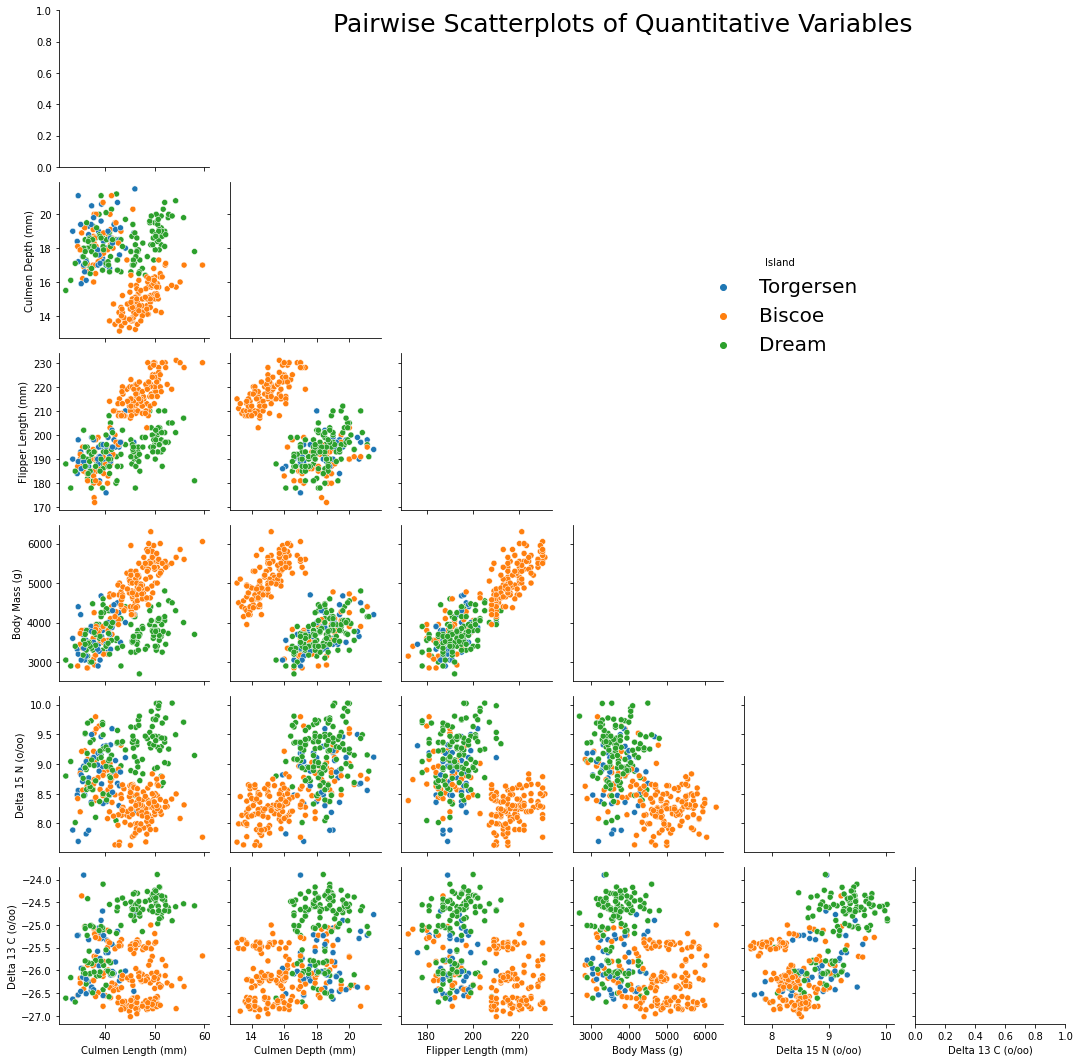

In [ ]:
# create paired scatterplots using seaborn
g = sns.PairGrid(new_penguins, hue = "Island", corner = True)
g.map_lower(sns.scatterplot)  # remove redundant plots

# add legend and title
g.add_legend(fontsize = 20, bbox_to_anchor= (0.7,0.7))
g.fig.suptitle("Pairwise Scatterplots of Quantitative Variables",fontsize=25)

On these scatterplots, the penguins from each island appear to cluster together. However, the clusters for Torgerson and Dream tend to overlap a lot, whereas the clusters for Biscoe tend to be more separate.

Regarding relationships between variables, Culmen Length, Culmen Depth, Flipper Length, and Body Mass have positive correlations with one another. Correlation appears to be the strongest between Flipper Length and Body Mass. Meanwhile, Delta 15 N and Delta 13 C have mostly no correlation with other variables.

Our next step is to compare variables between different penguin species. We will do this using boxplots to best visualize the variation within and between species. This way, we can see which values each variable centers around and whether certain species are significantly different from others.

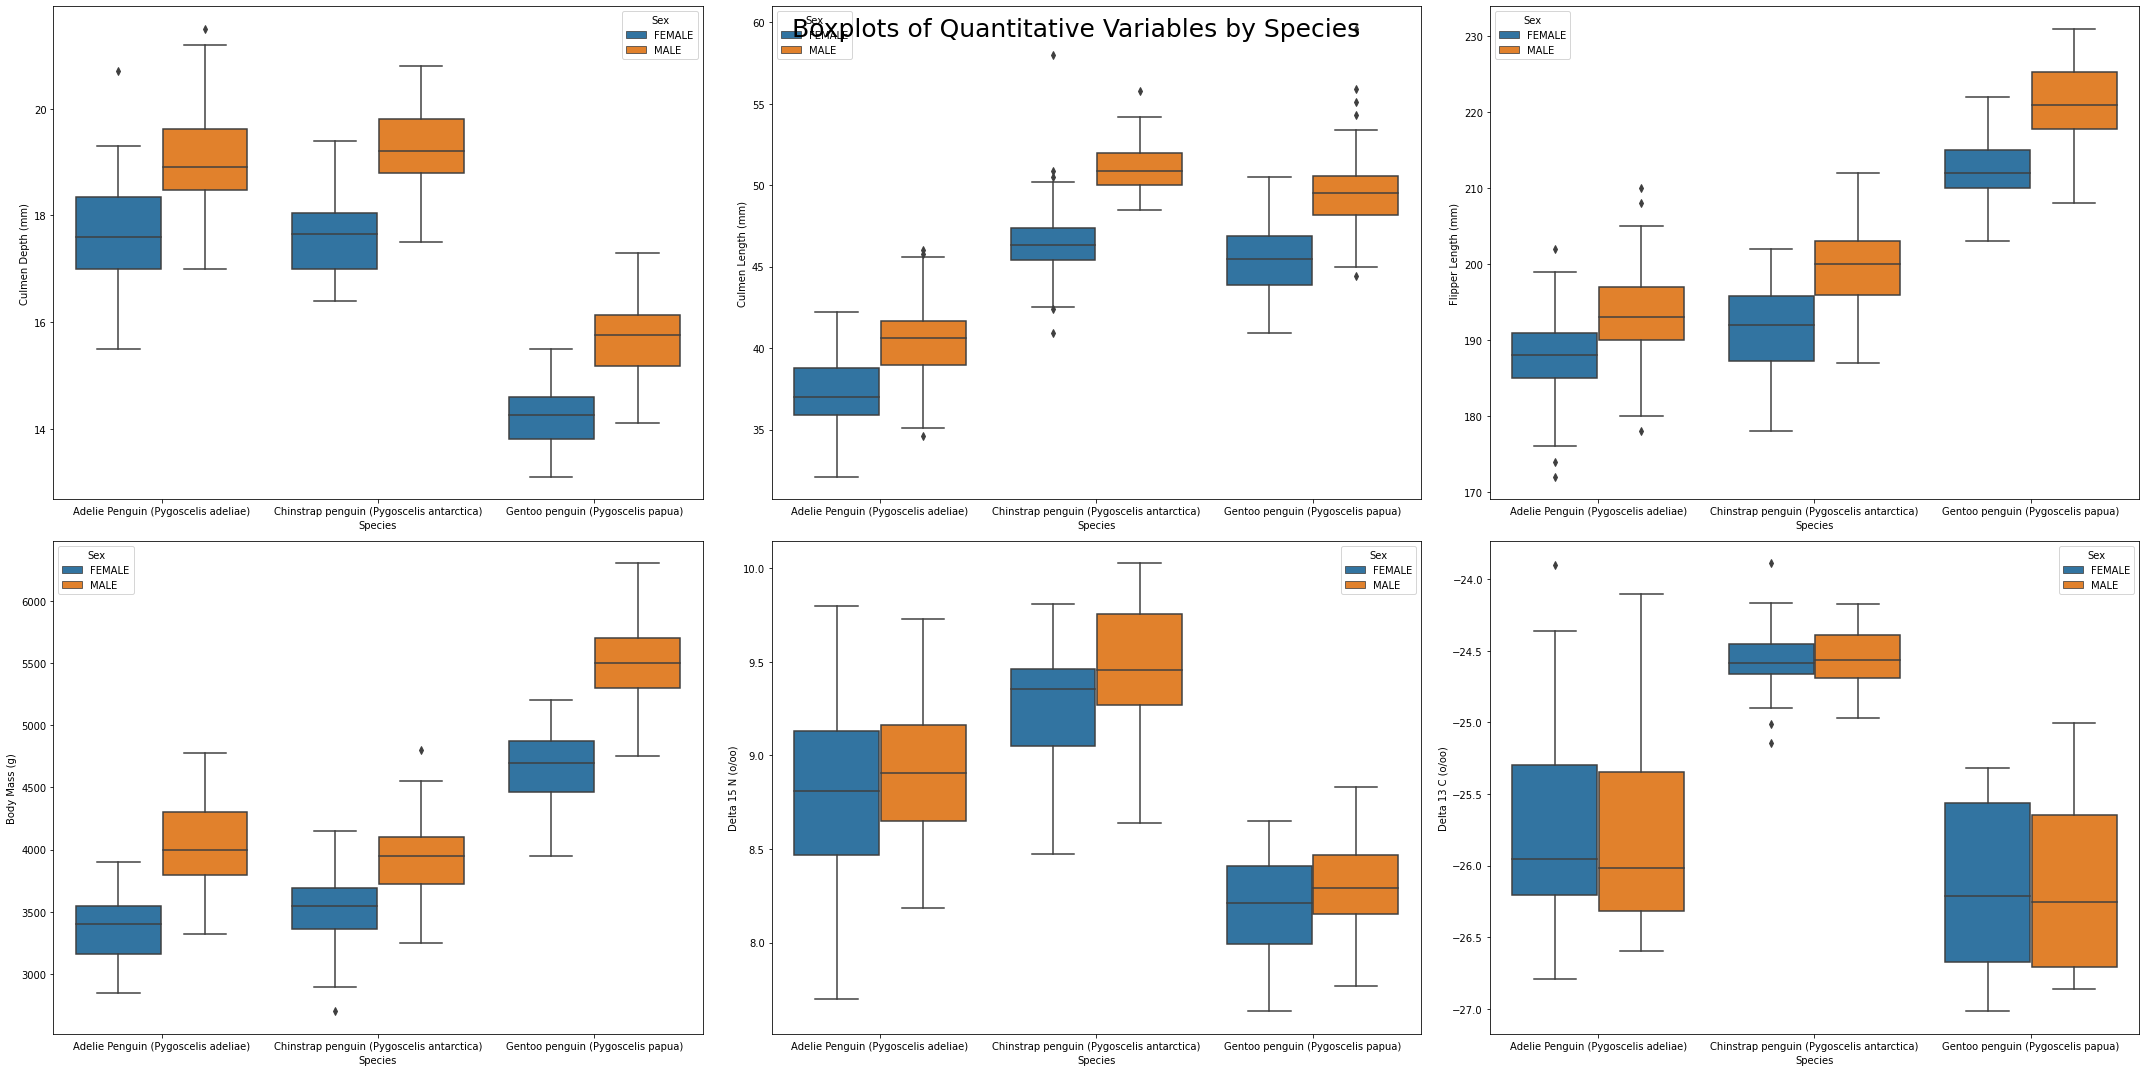

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (30,15))
sns.boxplot(ax = ax[0,0], x = "Species", y = "Culmen Depth (mm)",
            data = new_penguins, hue = "Sex")
sns.boxplot(ax = ax[0,1], x = "Species", y = "Culmen Length (mm)",
            data = new_penguins, hue = "Sex")
sns.boxplot(ax = ax[0,2], x = "Species", y = "Flipper Length (mm)",
            data = new_penguins, hue = "Sex")
sns.boxplot(ax = ax[1,0], x = "Species", y = "Body Mass (g)",
            data = new_penguins, hue = "Sex")
sns.boxplot(ax = ax[1,1], x = "Species", y = "Delta 15 N (o/oo)",
            data = new_penguins, hue = "Sex")
sns.boxplot(ax = ax[1,2], x = "Species", y = "Delta 13 C (o/oo)",
            data = new_penguins, hue = "Sex")
fig.suptitle("Boxplots of Quantitative Variables by Species",fontsize=25)
plt.tight_layout()

Based on these boxplots, we can see how a species might have significantly different values for a variable compared to the other species. For most of the variables, each species does not have too much variation, and there is minimal overlap between them, especially when separated by sex. The only exceptions are the variables Delta 15 N and Delta 13 C, which have a lot of variation within each species and a lot of overlap between species. As a result, it's difficult to distinguish differences between species for them.

The Gentoo penguin appears to have different values for Culmen Depth, Flipper Length, and Body Mass while the Adelie and Chinstrap Penguins have similar values. Meanwhile, the Adelie Penguin appears to have smaller Culmen Lengths than the Chinstrap aand Gentoo penguins.

For most variables, male penguins tend to have larger values, with very minimal overlap of the interquartile ranges for each sex for all variables except for Delta 15 N and Delta 13 C.

We will now further examine these differences, especially for Gentoo Penguin Culmen Depth, Adelile Penguin Culmen Length, and Male vs Female penguins. In the following table, we group the penguins within each species by sex and compare their mean Culmen Depths and Culmen Lengths.

In [ ]:
new_penguins.groupby(["Species","Sex"])[["Culmen Depth (mm)",
                                      "Culmen Length (mm)"]].mean().round(2)

Culmen Depth (mm)  \
Species                                   Sex                         
Adelie Penguin (Pygoscelis adeliae)       FEMALE              17.62   
                                          MALE                19.06   
Chinstrap penguin (Pygoscelis antarctica) FEMALE              17.59   
                                          MALE                19.25   
Gentoo penguin (Pygoscelis papua)         FEMALE              14.24   
                                          MALE                15.72   

                                                  Culmen Length (mm)  
Species                                   Sex                         
Adelie Penguin (Pygoscelis adeliae)       FEMALE               37.21  
                                          MALE                 40.43  
Chinstrap penguin (Pygoscelis antarctica) FEMALE               46.57  
                                          MALE                 51.07  
Gentoo penguin (Pygoscelis papua)         FEMALE               45.56  
                                          MALE                 49.51

Here, the difference between measurements for males and females becomes clear, with males having greater Culmen Depths and Culmen Lengths than females for each species. We can also see the smaller Culmen Depth of the Gentoo Penguin and the smaller Culmen Length of the Adelie Penguin. Given these observations, these variables seem to be promising for predicting the species of a penguin.

##Feature Selection

Based on our exploratory analysis results, we already suspect that Sex, Culmen Depth, and Culmen Length will be strong predictors for penguin species, but we still need to look closer at the correlation between variables to ensure that we are making the correct decision.

Since we will be selecting two quantitative variables to predict the data, we need to examine the cross validation scores of all combinations of two quantitative variables to find the pairing that will allow machine learning models to most accurately generalize over the whole dataset.

The following function will find the best pairing of quantitative variables for different machine learning models.

In [ ]:
def find_best(model, X, y):

    # create all possible combinations of the columns/variables
    combinations = [(a, b) for idx, a in enumerate(X_new.columns)
                           for b in X_new.columns[idx + 1:]]

    # initialize variables
    best_score = 0
    best_pair = None

    # iterate through each combination
    for pair in combinations:

        # cross validation score for combinatiton
        score = cross_val_score(model, X[list(pair)], y, cv = 10).mean()

        # update best score and best column if new score is higher
        if score > best_score:
            best_score = score  # update score
            best_pair = pair  # update column

    return best_pair, best_score

We will now apply this function for different machine learning models.

In [ ]:
# initializing classes
RF = RandomForestClassifier()  # random forest model
KNN = neighbors.KNeighborsClassifier()  # k-nearest neighbors algorithm

In [ ]:
# random forest feature selection
best_pair, best_score = find_best(RF, X_new, y_new)
best_pair, best_score

(('Culmen Length (mm)', 'Culmen Depth (mm)'), 0.956534090909091)

For the random forest model, the best combination was Culmen Length and Culmen Depth, with a cross validation score of 95.97%. This means that the model is predicted to have 95.97% accuracy.

In [ ]:
# k-nearest neighbors feature selection
best_pair,best_score = find_best(KNN, X_new, y_new)
best_pair, best_score

(('Culmen Length (mm)', 'Culmen Depth (mm)'), 0.965909090909091)

For the k-nearest neighbors algorithm, the best combination was Culmen Length and Culmen Depth, with a cross validation score of 96.59%. This means that the model is predicted to have 96.59% accuracy.

Now that we know the best combination of quantitative variables for each machine learning model, we must now determine which qualitative variable to use. Our options are Sex or Island.

The following function will allow us to see the cross validation scores for a combination of Culmen Length, Culmen Depth, and a qualitative variable. From this score, we can determine which of the qualitative variables will allow machine learning models to most accurately generalize over the whole dataset.

In [ ]:
def score_with_qual(model, X, qual):

  X_qual = X.copy()

  le = preprocessing.LabelEncoder()
  X_qual[qual] = le.fit_transform(new_penguins[qual])

  qual_score = cross_val_score(model, X_qual[['Culmen Length (mm)',
                                              'Culmen Depth (mm)',
                                              qual]], y_new, cv = 10).mean()

  return qual_score

We will now apply this function with the qualitative variables Sex and Island for different machine learning models.

In [ ]:
# random forest feature selection
sex_score = score_with_qual(RF, X_new, 'Sex')
island_score = score_with_qual(RF, X_new, 'Island')
sex_score, island_score

(0.987784090909091, 0.9875946969696969)

For the random forest model, the cross validation score is 98.78% with Sex and 98.45% with Island. This difference is also pretty small, with the variable Sex making the score slightly higher.

In [ ]:
# k-nearest neighbors feature selection
sex_score = score_with_qual(KNN, X_new, 'Sex')
island_score = score_with_qual(KNN, X_new, 'Island')
sex_score, island_score

(0.978409090909091, 0.9783143939393939)

For the k-nearest neighbors algorithm, the cross validation score is 97.84% with Sex and 97.83% with Island. This difference is very small, with the variable Sex making the score slightly higher.

We can now proceed with using the variables Culmen Length, Culmen Depth, and Sex for our machine learning models, given that this combination provided the highest cross validation score and is thus the most promising in terms of accurately generalizing over the whole dataset.

##Modeling


For the qualitative variable Sex, we will incorporate it by making separate graphs for Male and Female penguins. This makes sense due to the nature of qualitative variables, and it will allow us to view our species classifications by gender.

In order to make this separation, we will separate the testing data by Sex and use it later when making our species classification plots.

In [ ]:
df_test_MALE = test[test.Sex == 'MALE']  # male data
X_test_MALE, y_test_MALE = prep_ml(df_test_MALE)
df_test_FEMALE = test[test.Sex == 'FEMALE']  # female data
X_test_FEMALE, y_test_FEMALE = prep_ml(df_test_FEMALE)

We will now define a few functions that we will apply for each model to optimize them, evaluate their accuracy and performance, and view their results.

The first function will find the best k value with the best cross validation score for a given model.

In [ ]:
def find_best_k(c):

  fig, ax = plt.subplots() #create figure and initialize variables

  best_score = -np.inf  # initialize best score
  score = np.zeros(30)  # initialize scores

  for k in range(1,31):

      # apply model and fit data for current k
      model = c(k)
      trial = model.fit(X_train, y_train)

      # get cross validation score
      score[k-1] = cross_val_score(trial, X_train, y_train, cv=10).mean()

      # update best k and best score if new score is higher
      if score[k-1] > best_score:
          best_k = k
          best_score = score[k-1]

  # plot
  ax.scatter(np.arange(1,31), score, color = "purple")

  # add graph labels/titles
  ax.set(title = "Best k: "+str(best_k),
        xlabel = "k",
        ylabel = "Cross Val Score")

  return best_k, best_score

This next function will display a heatmap of the confusion matrix for each model so that we can visualize its performance.

In [ ]:
def disp_CM(c):

  c.fit(X_train,y_train)  # fit training data
  y_pred_test = c.predict(X_test)  # make prediction

  CM = confusion_matrix(y_test, y_pred_test) # create confusion matrix

  plt.figure(figsize = (10,7))
  sns.heatmap(CM, annot=True)  # plot confusion matrix as heatmap

  # label plot
  plt.title('Confusion Matrix for '+str(c))
  plt.xlabel("True Value")
  plt.ylabel("Predicted Value")
  plt.show()

This function will display the decision regions for each species by Culmen Length and Culmen Depth with a scatterplot of the data to show how the model fits. We will use it to graph the penguins species classifications based off of culmen length, culmen depth, and sex for each model.

In [ ]:
def plot_regions(c,X,y,best_value,sex):

    c.fit(X,y)  # fit data

    x0 = X[:,0]  # culmen length
    x1 = X[:,1]  # culmen depth

    # create grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx,yy = np.meshgrid(grid_x,grid_y)

    # convert into 1D array
    XX = xx.ravel()
    YY = yy.ravel()

    p = c.predict(np.c_[XX,YY])  # extract predictions
    p = p.reshape(xx.shape)  # convert back into 2D array

    fig,ax=plt.subplots(1)  # create figure

    ax.contourf(xx,yy,p,cmap="jet",alpha=0.2)  # plot decision regions
    ax.scatter(x0,x1,c=y,cmap="jet") # plot points

    # label graph
    ax.set(xlabel="Culmen Length (mm)",ylabel="Culmen Depth (mm)")
    plt.title(str(sex) + " Penguins Species classification based off \
culmen length and depth (k = %i)" % (best_value))

    # create legend
    ax.legend
    custom = [Line2D([], [], marker='.', color='darkred', linestyle='None'),
              Line2D([], [], marker='.', color='limegreen', linestyle='None'),
              Line2D([], [], marker='.',color='darkblue',linestyle='None')]
    plt.legend(custom, ['(Pygoscelis adeliae)',
                        '(Pygoscelis antarctica)',
                        '(Pygoscelis papua)'], loc='lower left')
    plt.show()

___

**Our first model is the Random Forest Model.**

We will begin by finding the k value with the variables that will allow us to have the most accurate predictions.

(30, 0.9706521739130436)

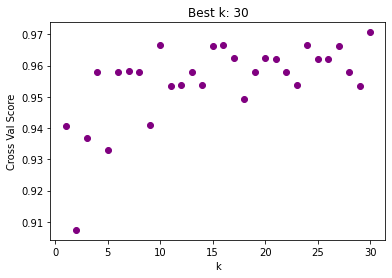

In [ ]:
RF_best_k, RF_best_score = find_best_k(RandomForestClassifier)
RF_best_k, RF_best_score

Our best k value is 16, and it has a best score of 97.07%. This means that it has very high accuracy. Moving forward, we can use our best k value to optimize our model's accuracy.

In [ ]:
RF = RandomForestClassifier(RF_best_k)

In order to better understand our random forest model, we can implement a confusion matrix to help visuialize the performance of it. The figure below plots our confusion matrix as a heatmap depicting the predictions.

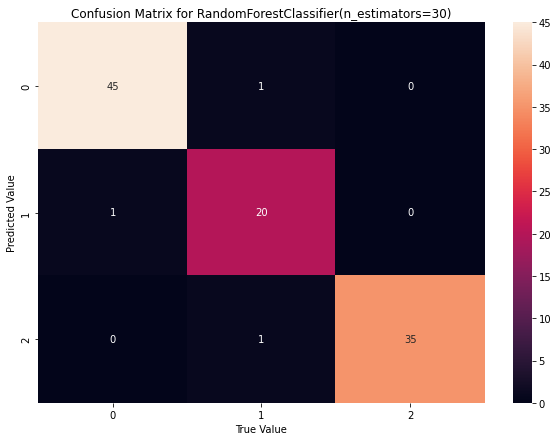

In [ ]:
disp_CM(RF)

Each index represents a species, so the values along the diagonal are the predictions that were accurate, while the other values are predictions that are inaccurate. We can observe that the numbers on the diagonal are large, meaning our model accurately predicted the species many times and is usually correct, but not always. There are still 1's in areas not on the diagonal, but the inaccurate predictions are minimal.

Now that we know that our model has high accuracy, we will plot decision regions for it using the plot_regions function that we defined earlier. We will create two decision regions, one for each sex.

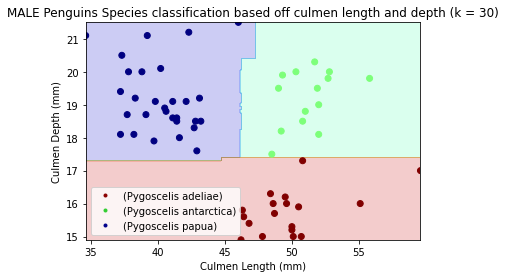

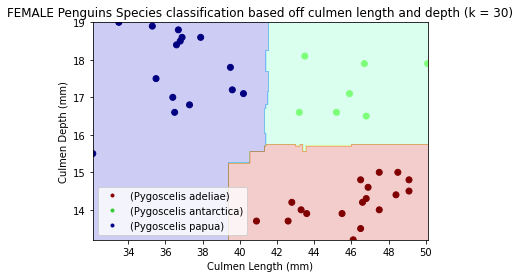

In [ ]:
plot_regions(RF, X_test_MALE, y_test_MALE, RF_best_k, test['Sex'].iloc[0])
plot_regions(RF, X_test_FEMALE, y_test_FEMALE, RF_best_k, test['Sex'].iloc[1])

Random forest is an advantageous model for our data because it allows for a highly accurate model all while minimizing overfitting. In particular, our data set had hundreds of entries and required a model that can maintain such a large amount of data. In addition, since we are working with qualitative and quantitative values, we needed an algorithm that works well with non linear data.

However, the minimization of overfitting could potentially sacrifice some of the model's accuracy. As seen on the decision regions plot, each region boundary is very straight and smooth. It is likely that real life differences in Culmen Length and Culmen Depth are not so simple, so our model may make mistakes in more varying cases.

In [ ]:
RF.fit(X_train,y_train)
RF.score(X_test,y_test)

0.970873786407767

Based on our visualizations and our score or 97.08%, we can see that our accuracy is very high, indicating that our model is a strong predictor of the test data.

___

**Our next model is the k-nearest neighbors algorithm.**

We will begin by finding the k value with the variables that will allow us to have the most accurate predictions.

(3, 0.9664855072463769)

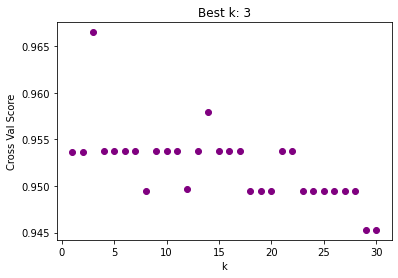

In [ ]:
KNN_best_k, KNN_best_score = find_best_k(neighbors.KNeighborsClassifier)
KNN_best_k, KNN_best_score

Our best k value is 3, and it has a best score of 96.65%. This means that it has very high accuracy. Moving forward, we can use our best k value to optimize our model's accuracy.

In [ ]:
KNN = neighbors.KNeighborsClassifier(KNN_best_k)

In order to better understand our k-nearest neighbors algorithm, we can implement a confusion matrix to help visuialize the performance of it. The figure below plots our confusion matrix as a heatmap depicting the predictions.

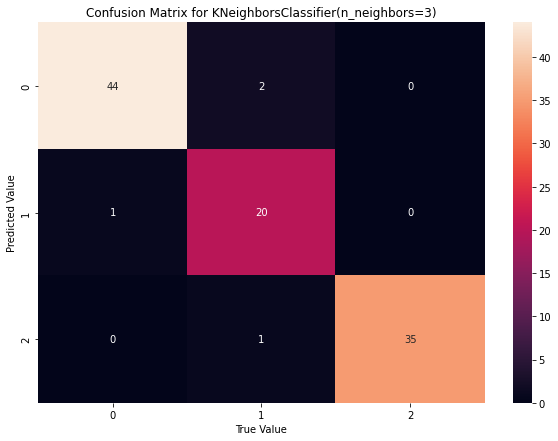

In [ ]:
disp_CM(KNN)

Each index represents a species, so the values along the diagonal are the predictions that were accurate, while the other values are predictions that are inaccurate. We can observe that the numbers on the diagonal are large, meaning our model accurately predicted the species many times and is usually correct, but not always. There are still 1's in areas not on the diagonal, but the inaccurate predictions are minimal.

Now that we know that our model has high accuracy, we will plot decision regions for it using the plot_regions function that we defined earlier. We will create two decision regions, one for each sex.

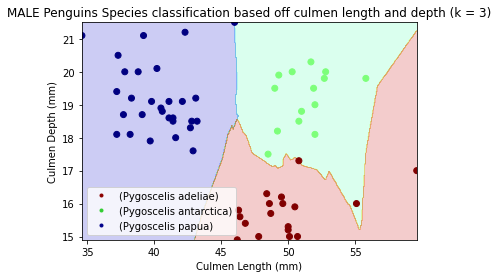

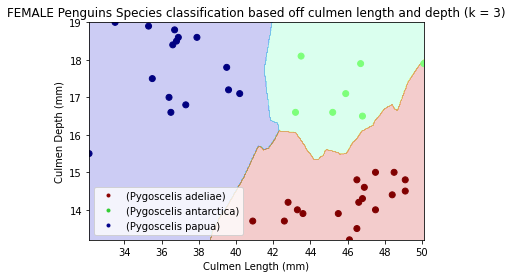

In [ ]:
plot_regions(KNN, X_test_MALE, y_test_MALE, KNN_best_k, test['Sex'].iloc[0])
plot_regions(KNN, X_test_FEMALE, y_test_FEMALE, KNN_best_k, test['Sex'].iloc[1])

For the K-Nearest Neigbors model, our descision regions borders are not as straight and are more contorted  to the data points on the plot. It is true that this shows a more accurate model, but there is a higher chance of overfitting. This means that the model could make mistakes due to the higher sensitivity it has to outliers.

In [ ]:
KNN.fit(X_train,y_train)
KNN.score(X_test,y_test)

0.9611650485436893

Based on our visualizations and our score or 96.12%, we can see that our accuracy is very high, indicating that our model is a strong predictor of the test data.

##Discussion

Both of our models had best cross validation scores over 95%, meaning that they both had very high accuracy. This could also be seen on the confusion matrices, with large values on the diagonal and few mistakes. The decision regions also helped visualize how our models accurately reflected the data, as the contours appeared to correctly separate the groups of species. When comparing the two models, the random forest model had a slightly higher accuracy of 98.06% while the k-nearest neighbors algorithm had an accuracy of 96.12%. Thus, the random forest model was slightly better than the k-nearest neighbors algorithm, but not by much.

For both of our models, we suggest a combination of the variables Culmen Length (mm), Culmen Depth (mm), and Sex. To come to this conclusion, we determined the combination of qualitative variables that would result in the highest cross validation score. This combination was Culmen Length (mm) and Culmen Depth (mm) for both models. To find our third variable, we explored Island and Sex after seeing potential patterns for both during our exploratory analysis. In the end, both models showed slightly higher accuracy with Sex compared to with Island, so we concluded that our combination of variables would be Culmen Length (mm), Culmen Depth (mm), and Sex.

If more data were available, our models would improve because they would have more data to train with. As a result, it would be able to develop a more accurate fit such that the model would be an even better predictor. If different data were available, such different characteristics that were more closely related to their species, our models would also improve. In our data we had characteristics that were largely related to physical penguin measurements. Although it would be more difficult to obtain, characteristics that reflect the penguins' lifestyles would likely be more indicative of Species.